In [11]:
%load_ext autoreload
%autoreload 2
import nest
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from tools import fix_figure, savefig
from method import IV
# from exana.statistics import plot_xcorr
import copy
# from IPython.display import display
%matplotlib inline

rc = {
    'figure.figsize' : (9, 9),
    'axes.labelsize' : 25,
    'lines.linewidth': 2,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'axes.titlesize' : 20,
    'font.size'      : 20,
    'legend.frameon' : False,
    'legend.fontsize': 20,
    'font.family'    : 'serif',
#     'font.serif'     : Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman
#     'font.sans-serif': Helvetica, Avant Garde, Computer Modern Sans serif
#     'font.cursive'   : Zapf Chancery
#     'font.monospace' : Courier, Computer Modern Typewriter
    'text.usetex'    : True}
sns.set(rc=rc)
sns.set_color_codes()
plt.rcParams.update(rc)

sns.set_style('white')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Slow synapse parameters

In [12]:
# more noise
# longer EPSP rise time 4 ms, duration 20 ms
par = {
    'msd'            : 1234, # Master seed
    'num_threads'    : 4,
    'N_neurons'      : 3,
    'res'            : 0.1, # Temporal resolution for simulation Delta t in ms
    'delay'          : 1.5, # Synaptic delay in ms
    'rate_p'         : 1000., # external poisson rate in Hz
    'J_p'            : .06,
    'gauss_mean'     : .1,
    'gauss_std'      : 1.1,
    # Neuron parameters
    't_ref'          : 2.0, # Duration of refractory period in ms
    'V_m'            : 0.0, # Membrane potential, initial condition in mV
    'E_L'            : 0.0, # Leak reversal potential in mV
    'V_reset'        : 0.0, # Reset potential of the membrane in mV
    'tau_m'          : 20.0, # Membrane timeconstant in ms
    'C_m'            : 1.0, # Capacity of the membrane in pF
    'V_th'           : 20.0, # Spike threshold in mV
    'tau_syn_ex'     : 4., # Time constants of the excitatory synaptic exponential function in ms
    'tau_syn_in'     : .1, # Time constants of the inhibitory synaptic exponential function in ms
    # Connection parameters
    'J_AB'           : 0., # mV
    'J_AC'           : 0,
    'J_BA'           : 0,
    'J_BC'           : .0002,
    'J_CA'           : 0,
    'J_CB'           : 0,
    'C'              : 10000,
    # Stimulation parameters
    'trial_amp_A'    : 10.0, # pA
    'trial_amp_B'    : 10.0, # pA
    'trial_period'   : 30.0, # ms
    'trial_duration' : 2.0, # ms
    'N_trials'       : 1000,
}

In [13]:
def simulate(par, stim_dist=None, **kwargs):
    par = copy.deepcopy(par)
    if kwargs:
        assert all(k in par for k in kwargs.keys())
        par.update(kwargs)
    if stim_dist is None:
        np.random.seed(par['msd'])
        stim_times = np.linspace(par['trial_period'], 
                                 par['N_trials'] * par['trial_period'],
                                 par['N_trials'])
    elif stim_dist == 'poisson':
        x = np.random.uniform(0, 1, par['N_trials'])
        poisson = - np.log(1 - x) * par['trial_period'] + par['trial_period']
        assert all(poisson > 0)
        stim_times = [poisson[0]]
        for idx, isi in enumerate(poisson[1:]):
            stim_times.append(stim_times[idx] + isi)
        stim_times = np.array(stim_times).round()
    print('simulating ', stim_times[-1])
    print('stimulating ', len(stim_times))
    # Set kernel
    nest.ResetKernel()
    nest.SetKernelStatus({"local_num_threads": par['num_threads']})
    N_vp = nest.GetKernelStatus(['total_num_virtual_procs'])[0]
    pyrngs = [np.random.RandomState(s) for s in range(par['msd'], par['msd'] + N_vp)]
    nest.SetKernelStatus({'grng_seed' : par['msd'] + N_vp})
    nest.SetKernelStatus({'rng_seeds' : range(par['msd'] + N_vp + 1, par['msd'] + 2 * N_vp + 1)})
    nest.SetStatus([0], [{"resolution": par['res']}])

    # Make the nodes
    nodes = nest.Create('iaf_psc_alpha', par['N_neurons'])
    keys = ['t_ref', 'V_m', 'E_L', 'V_reset', 'tau_m', 'C_m', 'V_th', 'tau_syn_ex', 'tau_syn_in']
    nest.SetStatus(nodes, [{k: par[k] for k in keys}])

    # Connect nodes
    names = ['A', 'B', 'C']
    nn = {
        'A': tuple([nodes[0]]),
        'B': tuple([nodes[1]]),
        'C': tuple([nodes[2]])
    }
    for key in ['J_AB', 'J_AC', 'J_BA', 'J_BC', 'J_CA', 'J_CB']:
        j = par.get(key)
        if j != 0 and j is not None:
            print('connecting ', key, j)
            s, r = nn[key[-2]], nn[key[-1]]
            conn_dict = {'rule': 'fixed_indegree', 'indegree': par['C']}
            nest.Connect(s, r, conn_dict,
                         {"weight": j, "delay": par['delay']})

    # Set background drive
    background = nest.Create("poisson_generator", 1,
                              params={"rate": par['rate_p']})
    nest.Connect(background, nodes, 
                 {'rule': 'fixed_indegree', 'indegree': 1},
                 {"weight": par['J_p'], "delay": par['res']})

    # Set channel noise
    channelnoise = nest.Create("noise_generator", 1,
                              params={"mean": par['gauss_mean'],
                                      'std': par['gauss_std']})
    nest.Connect(channelnoise, nodes)

    # Connect spike detector
    spks = nest.Create("spike_detector", 1,
                         params=[{"label": "Exc", "to_file": False}])
    # connect using all_to_all: all recorded excitatory neurons to one detector
    nest.Connect(nodes, spks)

    # Simulate one period without stimulation
    nest.Simulate(stim_times[0])

    # Set dc stimulation
    stims = []
    for n, a in enumerate([par['trial_amp_A'], par['trial_amp_B']]):
        print('setting stim {} {}'.format(names[n], a))
        stim = nest.Create(
            "dc_generator",
            params={'amplitude': a,
                    'start': 0.,
                    'stop': par['trial_duration']})
        nest.Connect(stim, tuple([nodes[n]]))
        stims.append(stim)

    # Run multiple trials
    for s in np.diff(stim_times):
        for stim in stims:
            nest.SetStatus(stim, {'origin': nest.GetKernelStatus()['time']})
        nest.Simulate(s)
    nest.Simulate(np.min(np.diff(stim_times)))

    # Organize data
    conns = nest.GetConnections(source=nodes, target=nodes)
    df = pd.DataFrame(nest.GetStatus(spks, 'events')[0])
    spiketrains = [{'times': np.array(attr['times']),
                    'sender': sndr,
                    'name': names[sndr - 1]}
                   for sndr, attr in df.groupby('senders')]
    data = {
        'spiketrains': spiketrains,
        'epoch': {'times': stim_times, 
                  'durations': [par['trial_duration']] * len(stim_times)},
        'connections': list(nest.GetStatus(conns, ('weight', 'source', 'target'))),
        'status': nest.GetKernelStatus(),
        'params': par
    }
    return data

In [18]:
# ws = np.arange(0.,1.1,.1)
ws = np.arange(0.,11.,1.)

In [19]:
datas = {}
for w in ws:
    dataa = simulate(par, N_trials=10000, trial_amp_A=w, trial_amp_B=w)
    datas[w] = dataa
np.savez('logreg_stimlim', data=datas)


simulating  300000.0
stimulating  10000
connecting  J_BC 0.0002
setting stim A 0.0
setting stim B 0.0
simulating  300000.0
stimulating  10000
connecting  J_BC 0.0002
setting stim A 1.0
setting stim B 1.0
simulating  300000.0
stimulating  10000
connecting  J_BC 0.0002
setting stim A 2.0
setting stim B 2.0
simulating  300000.0
stimulating  10000
connecting  J_BC 0.0002
setting stim A 3.0
setting stim B 3.0
simulating  300000.0
stimulating  10000
connecting  J_BC 0.0002
setting stim A 4.0
setting stim B 4.0
simulating  300000.0
stimulating  10000
connecting  J_BC 0.0002
setting stim A 5.0
setting stim B 5.0
simulating  300000.0
stimulating  10000
connecting  J_BC 0.0002
setting stim A 6.0
setting stim B 6.0
simulating  300000.0
stimulating  10000
connecting  J_BC 0.0002
setting stim A 7.0
setting stim B 7.0
simulating  300000.0
stimulating  10000
connecting  J_BC 0.0002
setting stim A 8.0
setting stim B 8.0
simulating  300000.0
stimulating  10000
connecting  J_BC 0.0002
setting stim A 9.0

In [20]:
# datas = np.load('logreg_stimlim.npz')['data'][()]
walds = []
walds_ns = []
logits = []
response_bins = [[0,1,2,3], [6,7,8,9]]
for w in ws:
    dataa = datas[w]
    wald = [[], []]
    wald_ns = [[], []]
    logit = [[], []]
    for n in [0,1]:
        conn = IV([dataa['spiketrains'][n]['times'], 
                   dataa['spiketrains'][2]['times']],
                     dataa['epoch']['times'],
                     response_bins=response_bins)
        wald[n].append(conn.wald())
        wald_ns[n].append(conn.wald_ns())
        logit[n].append(float(conn.logreg().coef_))
    walds.append(wald)
    walds_ns.append(wald_ns)
    logits.append(logit)
walds, logits = np.array(walds), np.array(logits)
walds_ns = np.array(walds_ns)

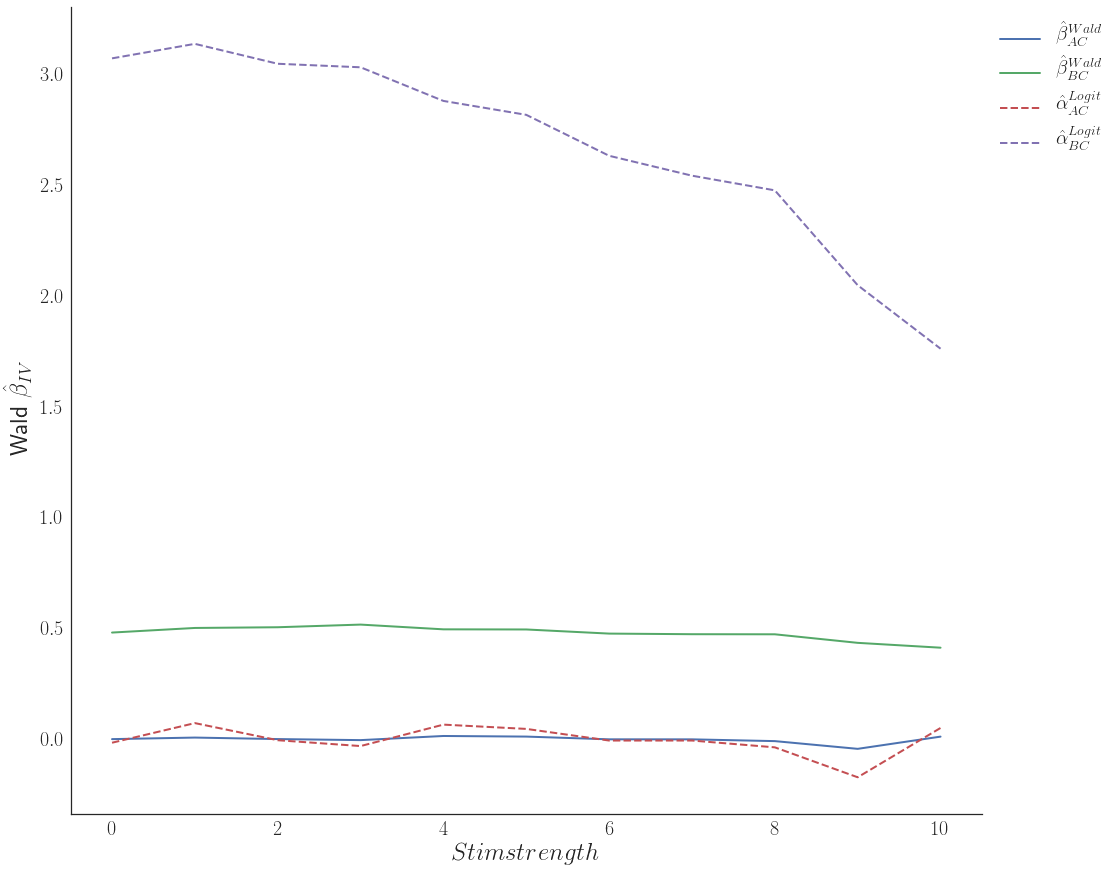

In [21]:
plt.plot(ws, walds[:,0], label='$\\hat\\beta_{AC}^{Wald}$')
plt.plot(ws, walds[:,1], label='$\\hat\\beta_{BC}^{Wald}$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$Stim strength$')
plt.ylabel('Wald $\\hat\\beta_{IV}$')
sns.despine()
fix_figure()

plt.plot(ws, logits[:,0], label='$\\hat\\alpha_{AC}^{Logit}$', ls='--')
plt.plot(ws, logits[:,1], label='$\\hat\\alpha_{BC}^{Logit}$', ls='--')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$Stim strength$')
plt.ylabel('Wald $\\hat\\beta_{IV}$')
sns.despine()
fix_figure()

In [5]:
def get_trials(data, n, binsize):
    period = np.min(np.diff(data['epoch']['times']))
    binsize = 1
    bins = np.arange(0, period + binsize, binsize)

    spike_train = data['spiketrains'][n]['times']
    trials = [spike_train[(spike_train > t) & (spike_train  <= t + period)] - t
              for t in data['epoch']['times']]
    ids = [np.ones(len(t)) * idx for idx, t in enumerate(trials)]

    times = [t for trial in trials for t in trial]
    trial_num = [i for ii in ids for i in ii]
    return times, trial_num, bins

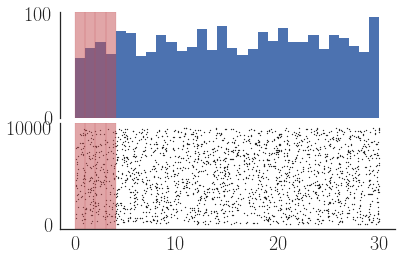

In [8]:
# plot B
fig = plt.figure()
gs = GridSpec(2, 1, hspace=0.05)
ax2 = fig.add_subplot(gs[1, 0])
ax1 = fig.add_subplot(gs[0, 0], sharex=ax2)
binsize = 1
times, trial_num, bins = get_trials(datas[ws[0]], 0, binsize=binsize)

ax2.scatter(times, trial_num, color='k', s=1)
ax1.hist(times, bins=bins, width=binsize);
sns.despine()
sns.despine(ax=ax1, bottom=True)
plt.setp(ax1.get_xticklabels(), visible=False)
for ax in (ax1, ax2):
    for r in response_bins[0]:
        ax.axvspan(r * binsize, (r + 1) * binsize,
                   color='r', alpha=.5, label='response')

In [30]:
datas[ws[1]]['params']

{'C': 10000,
 'C_m': 1.0,
 'E_L': 0.0,
 'J_AB': 0.0,
 'J_AC': 0,
 'J_BA': 0,
 'J_BC': 0.0002,
 'J_CA': 0,
 'J_CB': 0,
 'J_p': 0.06,
 'N_neurons': 3,
 'N_trials': 10000,
 'V_m': 0.0,
 'V_reset': 0.0,
 'V_th': 20.0,
 'delay': 1.5,
 'gauss_mean': 0.1,
 'gauss_std': 1.1,
 'msd': 1234,
 'num_threads': 4,
 'rate_p': 1000.0,
 'res': 0.1,
 't_ref': 2.0,
 'tau_m': 20.0,
 'tau_syn_ex': 4.0,
 'tau_syn_in': 0.1,
 'trial_amp_A': 1.0,
 'trial_amp_B': 1.0,
 'trial_duration': 2.0,
 'trial_period': 30.0}